<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




  0%|          | 0/10 [4:09:40<?, ?it/s]


 10%|█         | 1/10 [12:06<1:49:02, 726.97s/it]

 20%|██        | 2/10 [23:31<1:33:33, 701.73s/it]

 30%|███       | 3/10 [34:20<1:19:04, 677.77s/it]

 40%|████      | 4/10 [45:44<1:08:01, 680.21s/it]

 50%|█████     | 5/10 [1:06:07<1:13:00, 876.12s/it]

 60%|██████    | 6/10 [1:16:51<53:09, 797.29s/it]  

 70%|███████   | 7/10 [1:38:15<47:48, 956.27s/it]

 80%|████████  | 8/10 [1:58:41<34:44, 1042.26s/it]

 90%|█████████ | 9/10 [2:10:05<15:30, 930.12s/it] 

100%|██████████| 10/10 [2:21:29<00:00, 848.94s/it]



Best Performing Hyperparameters:
start                          03/05/25-200829
end                            03/05/25-201918
duration                            648.773254
round_epochs                               200
loss                                  1.936557
accuracy                               0.39774
val_loss                              2.387097
val_accuracy                            0.3063
units                                      120
hidden_activations                        relu
activation                             sigmoid
loss                  categorical_crossentropy
optimizer                                 adam
batch_size                                2000
Name: 2, dtype: object

Best Training Accuracy: 39.77% (Rounded: 40%)
Point Deduction: 0 points
Total Execution Time: 8489.45 seconds


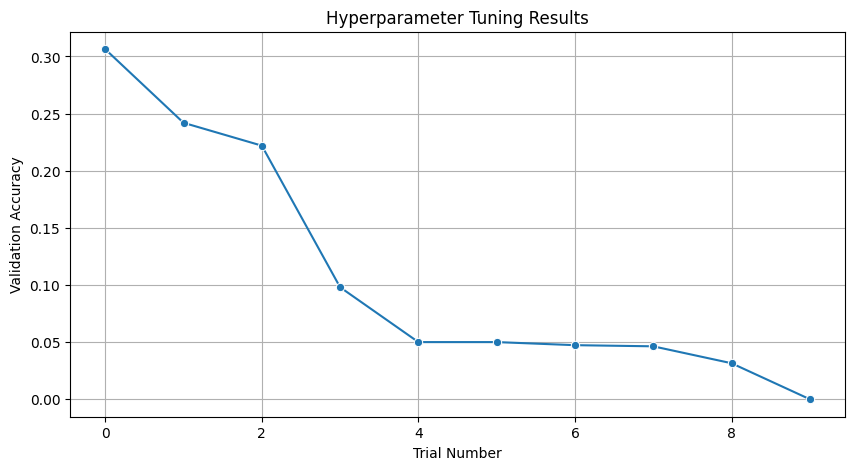

In [11]:
################################################################################
#Author: Arif H. Zaidy                                                         #
#Date: March 05, 2025                                                          #
#Course: CPSC 5440                                                             #
#Topic: Assignment 2                                                           #
#Description:                                                                  #
#This program performs hyperparameter tuning on a neural network using the     #
#Talos library with the CIFAR-100 dataset. It loads the dataset from           #
#Google Drive, defines a search space for hyperparameters, and trains          #
#models using different configurations. The best-performing model is           #
#selected based on validation accuracy, and results are visualized using       #
#a line plot. Finally, the script saves the results and plots to Google        #
#Drive for further analysis.                                                   #
################################################################################

import talos
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import time
from google.colab import drive

# Mount Google Drive to access stored files
drive.mount("/content/drive")

# Load CIFAR-100 dataset from Google Drive
with open('/content/drive/My Drive/train', 'rb') as file:
    train_dict = pickle.load(file, encoding='bytes')

with open('/content/drive/My Drive/test', 'rb') as file:
    test_dict = pickle.load(file, encoding='bytes')

# Extract training and testing data
X_train = train_dict[b'data']
y_train = train_dict[b'coarse_labels']
X_test = test_dict[b'data']
y_test = test_dict[b'coarse_labels']

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

# Define hyperparameter search space for Talos
p = {
    'units': [120, 240],  # Number of neurons in hidden layers
    'hidden_activations': ['relu', 'sigmoid'],  # Activation functions for hidden layers
    'activation': ['softmax', 'sigmoid'],  # Activation function for output layer
    'loss': ['mse', 'categorical_crossentropy'],  # Loss functions to test
    'optimizer': ['adam', 'adagrad'],  # Optimizers to experiment with
    'batch_size': [1000, 2000]  # Different batch sizes for training
}

# Define the model function for Talos hyperparameter tuning
def my_model(X_train, y_train, X_val, y_val, params):
    model = Sequential()
    # Input layer with specified number of units and activation function
    model.add(Dense(units=params['units'], activation=params['hidden_activations'], input_dim=X_train.shape[1]))

    # Adding 4 hidden layers with same units and activation function
    for _ in range(4):
        model.add(Dense(units=params['units'], activation=params['hidden_activations']))

    # Output layer with 100 units (for 100 classes) and chosen activation function
    model.add(Dense(units=100, activation=params['activation']))

    # Compile the model with selected loss function and optimizer
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

    # Train the model using provided training and validation data
    out = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size=params['batch_size'], epochs=200, verbose=0)

    return out, model

# Define the output file path for Talos results
csv_filename = "/drive/My Drive/talos_output"

# Start hyperparameter tuning using Talos
start_time = time.time()
t_object = talos.Scan(x=X_train, y=y_train, params=p, model=my_model, x_val=X_test, y_val=y_test, round_limit=10, experiment_name=csv_filename)

df = t_object.data  # Retrieve results as a dataframe

# Find the best performing hyperparameter set based on training accuracy
best_accuracy = df['accuracy'].max() * 100  # Convert to percentage
best_accuracy_rounded = round(best_accuracy)

# Calculate point deduction based on accuracy threshold
deduction = max(0, 20 - best_accuracy_rounded)

# Find the best-performing model based on validation accuracy
best_model_idx = df['val_accuracy'].idxmax()  # Get the row index with highest validation accuracy
best_params = df.iloc[best_model_idx]  # Extract best hyperparameters

# Print the best-performing hyperparameter set
print("\nBest Performing Hyperparameters:")
print(best_params)

# Display results
print(f"\nBest Training Accuracy: {best_accuracy:.2f}% (Rounded: {best_accuracy_rounded}%)")
print(f"Point Deduction: {deduction} points")
print(f"Total Execution Time: {time.time() - start_time:.2f} seconds")

# Sort results by validation accuracy
df_sorted = df.sort_values(by="val_accuracy", ascending=False)

# Plot validation accuracy for each trial
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(df_sorted)), y=df_sorted["val_accuracy"], marker="o")

plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning Results")
plt.grid()

# Save the figure to Google Drive
plt.savefig("/content/drive/My Drive/hyperparameter_tuning_plot.png", dpi=300)
plt.show()